# 1 - Split Datasets (randomly - but with equal distribution of efficacies)

In [83]:
import pandas as pd
starting_input_data_file = 'compiled_all_sirna_screen_data_6247-sirnas|5449-bdna|798-dualglo_MAR-11-2024'
df = pd.read_csv('new_input_data/'+starting_input_data_file+'.csv')
df = df[(df['screen_type'] == 'bDNA') & (df['species'] == 'human') & (df['chemical_scaffold'] == 'P3') ]

df.sort_values(by = ['expression_percent_normalized_by_max_min'],inplace=True)
df.reset_index(inplace=True, drop=True)

min_ext_dataset_size = int(len(df)/4)


df_ext = df.sample(n=min_ext_dataset_size).copy()##['expression_percent_normalized_by_max_min'].describe()

train_indexs = [x for x in list(df.index) if x not in list(df_ext.index)]

df_train = df.iloc[train_indexs].copy() 

print("Indicies are identical to starting df:",set(list(df.index)) == set(list(df_ext.index)+list(df_train.index)),
      '\n\tlengths:',len(set(list(df_ext.index))),len(set(list(df_train.index))),
      len(set(list(df_ext.index)+list(df_train.index))),len(set(list(df.index))))



import numpy as np

data_distribution_df_ = pd.DataFrame([np.round(df['expression_percent_normalized_by_max_min'].describe(),2),
              np.round(df_train['expression_percent_normalized_by_max_min'].describe(),2),
              np.round(df_ext['expression_percent_normalized_by_max_min'].describe(),2)], 
             index = ['original','train','ext']).transpose()

data_distribution_df_['range'] = data_distribution_df_.apply(lambda x:max(x)-min(x),axis=1)
data_distribution_df_.at['count','range'] = np.nan


if np.any(data_distribution_df_['range'] > 3):
    display(data_distribution_df_[['range']])
    raise Exception("ERROR: at least one statistic in sampled data distributions is off by more than the set threshold, resplit data again!")
    
display(data_distribution_df_)



import random
import string
seed = str(random.randint(0,9))+''.join(random.choices(string.ascii_uppercase , k=3))+str(random.randint(0,9))
print('\n\nseed:',seed,'\n\n')


print('\n\nExternal Dataset size:',
      len(df_ext),'\nTraining Dataset size:',len(df_train),
      '\nFull Dataset size:',len(df),'External+Training Sizes match full:',len(df)==len(df_train)+len(df_ext))


df_ext.reset_index(inplace=True, drop=True)
df_train.reset_index(inplace=True, drop=True)



# Export Files
from datetime import datetime
import calendar
month_ = calendar.month_abbr[datetime.now().month].upper() 
day_ = str(datetime.now().day)
if len(day_) <2:
    day_ = '0'+day_
year_ = str(datetime.now().year)
date_ = month_+'-'+day_+'-'+year_


ext_data_file =   'new_input_data/external_sirna_screen_data_bdna-human-p3_'+str(len(df_ext))  +'-sirnas_split-randomly_'+date_+'_'+seed+'.csv'
train_data_file = 'new_input_data/training_sirna_screen_data_bdna-human-p3_'+str(len(df_train))+'-sirnas_split-randomly_'+date_+'_'+seed+'.csv'

df_ext.to_csv(ext_data_file,index=False)
print('\nExternal Dataset saved to:\n\t',ext_data_file)

df_train.to_csv(train_data_file,index=False)
print('\nTraining Dataset saved to:\n\t',train_data_file)





Indicies are identical to starting df: True 
	lengths: 643 1930 2573 2573


,original,train,ext,range
count,2573.00,1930.00,643.00,NaN
mean,47.49,47.44,47.67,0.23
std,31.92,31.88,32.07,0.19
min,0.02,0.02,0.10,0.08
25%,19.23,19.76,18.80,0.96
50%,43.78,43.07,44.94,1.87
75%,74.32,74.43,73.93,0.50
max,100.00,100.00,100.00,0.00




seed: 1UCN2 




External Dataset size: 643 
Training Dataset size: 1930 
Full Dataset size: 2573 External+Training Sizes match full: True

External Dataset saved to:
	 new_input_data/external_sirna_screen_data_bdna-human-p3_643-sirnas_split-randomly_APR-04-2024_1UCN2.csv

Training Dataset saved to:
	 new_input_data/training_sirna_screen_data_bdna-human-p3_1930-sirnas_split-randomly_APR-04-2024_1UCN2.csv


In [ ]:
'new_input_data/external_sirna_screen_data_bdna-human-p3_643-sirnas_split-randomly_APR-04-2024_1UCN2.csv'
'new_input_data/training_sirna_screen_data_bdna-human-p3_1930-sirnas_split-randomly_APR-04-2024_1UCN2.csv'





# 2 - Split Dataset (keeping screens within each split)

In [29]:
import pandas as pd
starting_input_data_file = 'compiled_all_sirna_screen_data_6247-sirnas|5449-bdna|798-dualglo_MAR-11-2024'
df = pd.read_csv('new_input_data/'+starting_input_data_file+'.csv')
df = df[(df['screen_type'] == 'bDNA') & (df['species'] == 'human') & (df['chemical_scaffold'] == 'P3') ]

df.sort_values(by=['experiment_name'],inplace=True)
df.reset_index(inplace=True,drop=True)


import random
import string
seed = str(random.randint(0,9))+''.join(random.choices(string.ascii_uppercase , k=3))+str(random.randint(0,9))
print('\n\nseed:',seed,'\n\n')


# Split Data into two sets (one for Training/Paramopt/Test another for External Eval)
exper_df = pd.DataFrame(df['experiment_name'].value_counts())
exper_df.reset_index(inplace=True,drop=False)
exper_df.columns = ['experiment_name','counts']
indx_ls = list(range(len(exper_df)))

random.shuffle(indx_ls)
exper_df['shuffle_indx'] = indx_ls
exper_df.sort_values(by=['shuffle_indx'],inplace=True)

# display(exper_df)

# Pick ~1/4 to go into one set and ~3/4 to go in another
min_ext_dataset_size = int(len(df)/4)
for i in range(len(exper_df)):
    sum_ct = sum(exper_df.iloc[0:i]['counts'])
    if sum_ct >= min_ext_dataset_size:
        break
        

print('\nindex:',i, '\nMinimum External dataset size:',min_ext_dataset_size,'\nActual External dataset size:', sum_ct)


ext_dataset_expers = list(exper_df.iloc[0:i]['experiment_name'])
df_ext = df[df['experiment_name'].isin(ext_dataset_expers)]
df_train = df[~df['experiment_name'].isin(ext_dataset_expers)]

print('\n\nExternal Dataset size:',
      len(df_ext),'\nTraining Dataset size:',len(df_train),
      '\nFull Dataset size:',len(df),'External+Training Sizes match full:',len(df)==len(df_train)+len(df_ext))


df_ext.reset_index(inplace=True, drop=True)
df_train.reset_index(inplace=True, drop=True)


# Export Files
from datetime import datetime
import calendar
month_ = calendar.month_abbr[datetime.now().month].upper() 
day_ = str(datetime.now().day)
if len(day_) <2:
    day_ = '0'+day_
year_ = str(datetime.now().year)
date_ = month_+'-'+day_+'-'+year_


ext_data_file =   'new_input_data/external_sirna_screen_data_bdna-human-p3_'+str(len(df_ext))  +'-sirnas_split-by-exper_'+date_+'_'+seed+'.csv'
train_data_file = 'new_input_data/training_sirna_screen_data_bdna-human-p3_'+str(len(df_train))+'-sirnas_split-by-exper_'+date_+'_'+seed+'.csv'


df_ext.to_csv(ext_data_file,index=False)
print('\nExternal Dataset saved to:\n\t',ext_data_file)

df_train.to_csv(train_data_file,index=False)
print('\nTraining Dataset saved to:\n\t',train_data_file)




seed: 4ZJO7

index: 11 
Minimum External dataset size: 643 
Actual External dataset size: 679


External Dataset size: 679 
Training Dataset size: 1894 
Full Dataset size: 2573 External+Training Sizes match full: True
External Dataset saved to:
	 new_input_data/external_sirna_screen_data_bdna-human-p3_679-sirnas_split-by-exper_APR-04-2024_4ZJO7.csv
Training Dataset saved to:
	 new_input_data/training_sirna_screen_data_bdna-human-p3_1894-sirnas_split-by-exper_APR-04-2024_4ZJO7.csv


# Create Shuffled *Expression* dataset




Before shuffling:
0 669


After shuffling:
78 627

Before shuffling expression %:
29.0294057 111.43666666666668 0.1 100.0


After shuffling expression %:
98.9416187 80.55563333 98.69932887994058 76.71663008721532
Figure saved to: new_input_data/for_troubleshooting_and_testing/figures/shuffled-expression_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024_3157.png
Data saved to:
	 new_input_data/for_troubleshooting_and_testing/shuffled-expression_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024_3157.csv


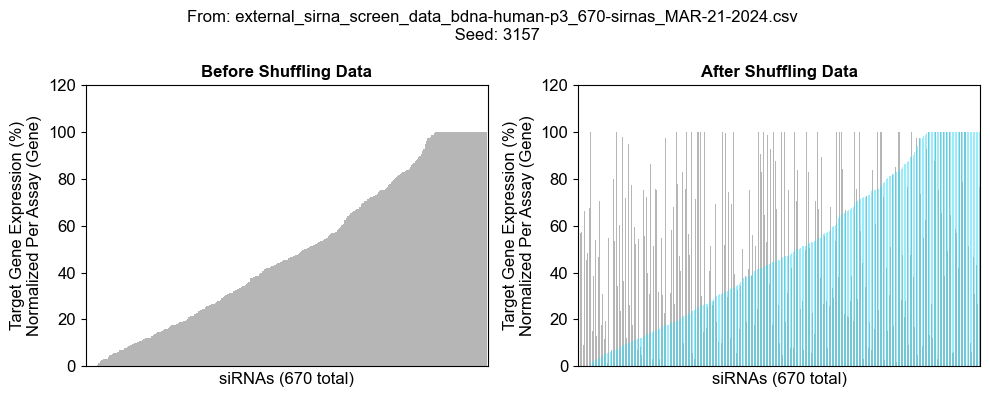

In [72]:
# Create a shuffled Dataset
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
# TRAIN_data_file = 'training_sirna_screen_data_bdna-human-p3_1903-sirnas_MAR-21-2024.csv'
input_data_file = 'external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df


# shuffle target expression data ONLY
exp_ls = list(df['expression_percent'])
exp_norm_ls = list(df['expression_percent_normalized_by_max_min'])
indx_ls = list(df.index)

print('\nBefore shuffling:')
print(indx_ls[0],indx_ls[-1])


import random
random.shuffle(indx_ls)
seed_ = str(random.randint(1000,9999))

print('\n\nAfter shuffling:')
print(indx_ls[0],indx_ls[-1])

exp_ls_shuffled = list(df.iloc[indx_ls]['expression_percent'])
exp_norm_ls_shuffled = list(df.iloc[indx_ls]['expression_percent_normalized_by_max_min'])

print('\nBefore shuffling expression %:')
print(exp_ls[0],exp_ls[-1],exp_norm_ls[0],exp_norm_ls[-1])
print('\n\nAfter shuffling expression %:')
print(exp_ls_shuffled[0],exp_ls_shuffled[-1],exp_norm_ls_shuffled[0],exp_norm_ls_shuffled[-1])

# update data
# create column with old data
df['unshuffled_expression_percent'] = exp_ls
df['unshuffled_expression_percent_normalized_by_max_min'] = exp_norm_ls

df['expression_percent'] = exp_ls_shuffled
df['expression_percent_normalized_by_max_min'] = exp_norm_ls_shuffled



from matplotlib import pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (6, 4),
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'font.family': 'Arial',
          }
pylab.rcParams.update(params)


fig, axs = plt.subplots(1,2)
fig.set_size_inches(w=10, h=4)

exp_key_1 = 'unshuffled_expression_percent_normalized_by_max_min'

axs[0].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_1],
    color='#B6B6B7',
    # width=(1.0),
)

axs[0].set_ylim(0, max(df[exp_key_1]) + 0.2 * max(df[exp_key_1]))
axs[0].set_xlim(0, len(df))
axs[0].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[0].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[0].set_title('Before Shuffling Data',fontweight='bold')

exp_key_2 = 'expression_percent_normalized_by_max_min'

axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_2], # NOTE: still sorted by the unshuffled expression (exp_key_1)
    color='#B6B6B7',
    # width=(1.0),
)

# second bar overlaying is the sorted shuffled expressions
axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_2)[exp_key_2], 
    color='#32DBF8',
    alpha=0.5,
    # width=(1.0),
)

axs[1].set_ylim(0, max(df[exp_key_2]) + 0.2 * max(df[exp_key_2]))
axs[1].set_xlim(0, len(df))
axs[1].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[1].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[1].set_title('After Shuffling Data',fontweight='bold')

fig.suptitle('From: '+input_data_file+'.csv \n Seed: '+seed_)
fig.tight_layout()

# ** SAVE FIGURE **
plt.rcParams['svg.fonttype'] = 'none'  # exports text as strings rather than vector paths (images)
fnm_ = 'new_input_data/for_troubleshooting_and_testing/figures/'+'shuffled-expression_'+input_data_file+'_'+seed_
fig.savefig(fnm_ + '.svg', format='svg', transparent=True)

fig.savefig(fnm_ + '.png', format='png', dpi=300, transparent=False)
print('Figure saved to:', fnm_ + '.png')


# Export shuffled data
df.drop(columns = ['unshuffled_expression_percent','unshuffled_expression_percent_normalized_by_max_min'], inplace=True)
out_file = 'shuffled-expression_'+input_data_file+'_'+seed_+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)


# Create Randomized *Expression*  Dataset


Before randomizing:
0 669
Seed:  8371


After randomizing:
0 669

Before randomizing expression %:
0.1 100.0


After randomizing expression %:
88.32 65.96
Figure saved to: new_input_data/for_troubleshooting_and_testing/figures/randomized-expression_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024_8371.png
Data saved to:
	 new_input_data/for_troubleshooting_and_testing/randomized-expression_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024_8371.csv


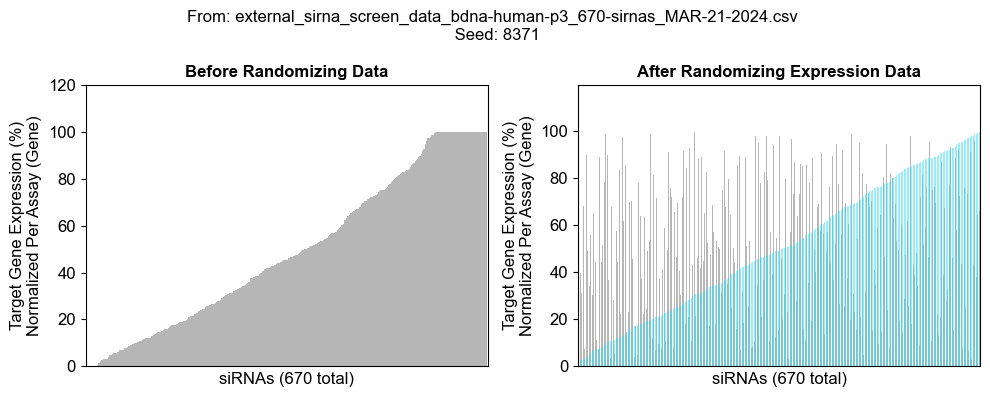

In [74]:
# Create a randomized Dataset
import numpy as np
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df


# randomize target expression data ONLY
exp_norm_ls = list(df['expression_percent_normalized_by_max_min'])
indx_ls = list(df.index)

print('\nBefore randomizing:')
print(indx_ls[0],indx_ls[-1])


import random
# random.shuffle(indx_ls)
seed_ = str(random.randint(1000,9999))
print("Seed: ",seed_)
print('\n\nAfter randomizing:')
print(indx_ls[0],indx_ls[-1])


exp_norm_ls_rand = [np.round(random.uniform(1, 100),2) for x in list(range(len(df)))]

print('\nBefore randomizing expression %:')
print(exp_norm_ls[0],exp_norm_ls[-1])
print('\n\nAfter randomizing expression %:')
print(exp_norm_ls_rand[0],exp_norm_ls_rand[-1])

# update data
# create column with old data
df['unrandomized_expression_percent_normalized_by_max_min'] = exp_norm_ls

df['expression_percent_normalized_by_max_min'] = exp_norm_ls_rand



from matplotlib import pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
          'figure.figsize': (6, 4),
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'font.family': 'Arial',
          }
pylab.rcParams.update(params)


fig, axs = plt.subplots(1,2)
fig.set_size_inches(w=10, h=4)

exp_key_1 = 'unrandomized_expression_percent_normalized_by_max_min'

axs[0].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_1],
    color='#B6B6B7',
    # width=(1.0),
)

axs[0].set_ylim(0, max(df[exp_key_1]) + 0.2 * max(df[exp_key_1]))
axs[0].set_xlim(0, len(df))
axs[0].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[0].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[0].set_title('Before Randomizing Data',fontweight='bold')

exp_key_2 = 'expression_percent_normalized_by_max_min'

axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_2], 
    color='#B6B6B7',
    # width=(1.0),
)

# second bar overlaying is the sorted randomized expressions
axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_2)[exp_key_2], 
    color='#32DBF8',
    alpha=0.5,
    # width=(1.0),
)
axs[1].set_ylim(0, max(df[exp_key_2]) + 0.2 * max(df[exp_key_2]))
axs[1].set_xlim(0, len(df))
axs[1].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[1].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[1].set_title('After Randomizing Expression Data',fontweight='bold')

fig.suptitle('From: '+input_data_file+'.csv \n Seed: '+seed_)
fig.tight_layout()

# ** SAVE FIGURE **
plt.rcParams['svg.fonttype'] = 'none'  # exports text as strings rather than vector paths (images)
fnm_ = 'new_input_data/for_troubleshooting_and_testing/figures/'+'randomized-expression_'+input_data_file+'_'+seed_
fig.savefig(fnm_ + '.svg', format='svg', transparent=True)

fig.savefig(fnm_ + '.png', format='png', dpi=300, transparent=False)
print('Figure saved to:', fnm_ + '.png')


# Export randomized data
df.drop(columns = ['unrandomized_expression_percent_normalized_by_max_min'], inplace=True)
out_file = 'randomized-expression_'+input_data_file+'_'+seed_+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)


# Create *Shuffled Sequence* dataset

In [75]:
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df

# shuffle flanking_sequence_1 and 16mer_complementary_region and mismatch_16mer_for_flanks
flank_seq_ls = list(df['flanking_sequence_1'])
comp_region_seq_ls = list(df['16mer_complementary_region'])
mismatch_ls = list(df['mismatch_16mer_for_flanks'])

indx_ls = list(df.index)

print('\nBefore shuffling:')
print(indx_ls[0],indx_ls[-1])
print('\n\nflanking_sequence_1:\n')
print(df['flanking_sequence_1'])
print('\n\n16mer_complementary_region:\n')
print(df['16mer_complementary_region'])
print('\n\nmismatch_16mer_for_flanks:\n')
print(df['mismatch_16mer_for_flanks'])

import random
random.shuffle(indx_ls)
seed_ = str(random.randint(1000,9999))

print('\n\nAfter shuffling:')
print(indx_ls[0],indx_ls[-1])

flank_seq_ls_shuffled = list(df.iloc[indx_ls]['flanking_sequence_1'])
comp_region_seq_ls_shuffled = list(df.iloc[indx_ls]['16mer_complementary_region'])
mismatch_ls_shuffled = list(df.iloc[indx_ls]['mismatch_16mer_for_flanks'])

print('\nBefore shuffling sequences:')
print(flank_seq_ls[0],'\n\n',flank_seq_ls[-1],'\n\n',
      comp_region_seq_ls[0],'\n',comp_region_seq_ls[-1],'\n',
      mismatch_ls[-1],'\n',mismatch_ls[-1])

print('\n\nAfter shuffling sequences:')
print(flank_seq_ls_shuffled[0],'\n\n',flank_seq_ls_shuffled[-1],'\n\n',
      comp_region_seq_ls_shuffled[0],'\n',comp_region_seq_ls_shuffled[-1],'\n',
      mismatch_ls_shuffled[-1],'\n',mismatch_ls_shuffled[-1])

# update data
df['flanking_sequence_1'] = flank_seq_ls_shuffled
df['16mer_complementary_region'] = comp_region_seq_ls_shuffled
df['mismatch_16mer_for_flanks'] = mismatch_ls_shuffled
    
print('\n\n\nAfter shuffling:')
print('\n\nflanking_sequence_1:\n')
print(df['flanking_sequence_1'])
print('\n\n16mer_complementary_region:\n')
print(df['16mer_complementary_region'])
print('\n\nmismatch_16mer_for_flanks:\n')
print(df['mismatch_16mer_for_flanks'])

# Export data
out_file = 'shuffled-sequences_'+input_data_file+'_'+seed_+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)



Before shuffling:
0 669


flanking_sequence_1:

0      CTTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGT...
1      TTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGTT...
2      TGTGGGGAACTTGGGGTGGAGCAGAGAAGTTTCTGTATTCAGCTGC...
3      AGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGTTTCTGT...
4      CTGCTTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGA...
                             ...                        
665    TAGTTCCTTTTTCAGGCTCATTTGCTTTTGCTTTTTTGTTGAATGA...
666    CCAGGTGCAAAGGCAGCTTAGCTACTGAGGTAGCGAATGTTCTGAG...
667    TTTTTTTTTTCCTTTTTTATTGATTGGGCCTGAATACAGGCTTTCT...
668    TTTTTTCCATTGTAAATATTTCTGTAAATACTACCAATTGGAAATT...
669    GAAAATAGCTAAAAGTCTAATTTTTACCCATTTAGACTTTGTTATT...
Name: flanking_sequence_1, Length: 670, dtype: object


16mer_complementary_region:

0      ACACGACAGAATAAAG
1      CACGACAGAATAAAGA
2      ACTCGATGTCAATGAG
3      CAGAATAAAGACTCGA
4      AAGACACGACAGAATA
             ...       
665    ACTACTGTCTATATTT
666    GAATGATTCCAATCGT
667    ATTGGATTTGTAAAAC
668    GCTGTGATCTTTGGAG

# Create *Randomized Sequence* dataset

In [76]:
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df



import random
seed_ = str(random.randint(1000,9999))
# Generate flanking_sequence_1 
#  AND update 16mer_complementary_region and mismatch_16mer_for_flanks
# generate flanking sequences --> sequence of A,T,C,G of lenght 226
flank_seq_ls_rand = [''.join([random.choice(['A','T','C','G']) for x in list(range(226))]) for y in list(range(len(df)))]

# obtain 16mers for each flanking sequence
comp_region_seq_ls_rand = [x[105:105+16]  for x in flank_seq_ls_rand]
# make mismatch all perfect (since random data all have matching 16mers to flanks)
mismatch_ls_rand = len(df)*['16mer perfect match to target']

print('\n\n\nBefore randomizing sequences:')
print('\n\nflanking_sequence_1:\n')
print(df['flanking_sequence_1'])
print('\n\n16mer_complementary_region:\n')
print(df['16mer_complementary_region'])
print('\n\nmismatch_16mer_for_flanks:\n')
print(df['mismatch_16mer_for_flanks'])



# update data
df['flanking_sequence_1'] = flank_seq_ls_rand
df['16mer_complementary_region'] = comp_region_seq_ls_rand
df['mismatch_16mer_for_flanks'] = mismatch_ls_rand
    
print('\n\n\nAfter randomizing sequences:')
print('\n\nflanking_sequence_1:\n')
print(df['flanking_sequence_1'])
print('\n\n16mer_complementary_region:\n')
print(df['16mer_complementary_region'])
print('\n\nmismatch_16mer_for_flanks:\n')
print(df['mismatch_16mer_for_flanks'])

# Export data
out_file = 'randomized-sequences_'+input_data_file+'_'+seed_+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)





Before randomizing sequences:


flanking_sequence_1:

0      CTTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGT...
1      TTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGTT...
2      TGTGGGGAACTTGGGGTGGAGCAGAGAAGTTTCTGTATTCAGCTGC...
3      AGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGAAGTTTCTGT...
4      CTGCTTCCCAGACCACAGCTGTGGGGAACTTGGGGTGGAGCAGAGA...
                             ...                        
665    TAGTTCCTTTTTCAGGCTCATTTGCTTTTGCTTTTTTGTTGAATGA...
666    CCAGGTGCAAAGGCAGCTTAGCTACTGAGGTAGCGAATGTTCTGAG...
667    TTTTTTTTTTCCTTTTTTATTGATTGGGCCTGAATACAGGCTTTCT...
668    TTTTTTCCATTGTAAATATTTCTGTAAATACTACCAATTGGAAATT...
669    GAAAATAGCTAAAAGTCTAATTTTTACCCATTTAGACTTTGTTATT...
Name: flanking_sequence_1, Length: 670, dtype: object


16mer_complementary_region:

0      ACACGACAGAATAAAG
1      CACGACAGAATAAAGA
2      ACTCGATGTCAATGAG
3      CAGAATAAAGACTCGA
4      AAGACACGACAGAATA
             ...       
665    ACTACTGTCTATATTT
666    GAATGATTCCAATCGT
667    ATTGGATTTGTAAAAC
668    GCTGTGAT

# Create Dataset with all Negative Labels (*i.e.* all Inefficient Efficacies)

Figure saved to: new_input_data/for_troubleshooting_and_testing/figures/all-negative-labels_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024.png
Data saved to:
	 new_input_data/for_troubleshooting_and_testing/all-negative-labels_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024.csv


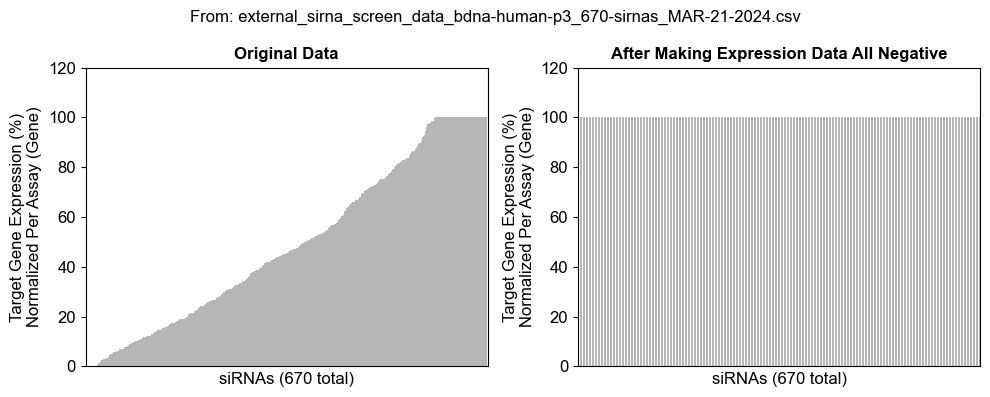

In [77]:
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df

df['actual_expression_percent_normalized_by_max_min'] = df['expression_percent_normalized_by_max_min']

df['expression_percent_normalized_by_max_min'] = len(df)*[100.0]
df['expression_percent'] = len(df)*[100.0]

# Plot Data

fig, axs = plt.subplots(1,2)
fig.set_size_inches(w=10, h=4)

exp_key_1 = 'actual_expression_percent_normalized_by_max_min'

axs[0].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_1],
    color='#B6B6B7',
    # width=(1.0),
)

axs[0].set_ylim(0, max(df[exp_key_1]) + 0.2 * max(df[exp_key_1]))
axs[0].set_xlim(0, len(df))
axs[0].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[0].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[0].set_title('Original Data',fontweight='bold')

exp_key_2 = 'expression_percent_normalized_by_max_min'

axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_2)[exp_key_2], 
    color='#B6B6B7',
    # width=(1.0),
)

axs[1].set_ylim(0, max(df[exp_key_2]) + 0.2 * max(df[exp_key_2]))
axs[1].set_xlim(0, len(df))
axs[1].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[1].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[1].set_title('After Making Expression Data All Negative',fontweight='bold')

fig.suptitle('From: '+input_data_file+'.csv')
fig.tight_layout()

# ** SAVE FIGURE **
plt.rcParams['svg.fonttype'] = 'none'  # exports text as strings rather than vector paths (images)
fnm_ = 'new_input_data/for_troubleshooting_and_testing/figures/'+'all-negative-labels_'+input_data_file
fig.savefig(fnm_ + '.svg', format='svg', transparent=True)

fig.savefig(fnm_ + '.png', format='png', dpi=300, transparent=False)
print('Figure saved to:', fnm_ + '.png')



df.drop(columns = ['actual_expression_percent_normalized_by_max_min'], inplace=True)


# Export data
out_file = 'all-negative-labels_'+input_data_file+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)



# Create Dataset with all Positive Labels (*i.e.* all Efficient Efficacies)

Figure saved to: new_input_data/for_troubleshooting_and_testing/figures/all-positive-labels_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024.png
Data saved to:
	 new_input_data/for_troubleshooting_and_testing/all-positive-labels_external_sirna_screen_data_bdna-human-p3_670-sirnas_MAR-21-2024.csv


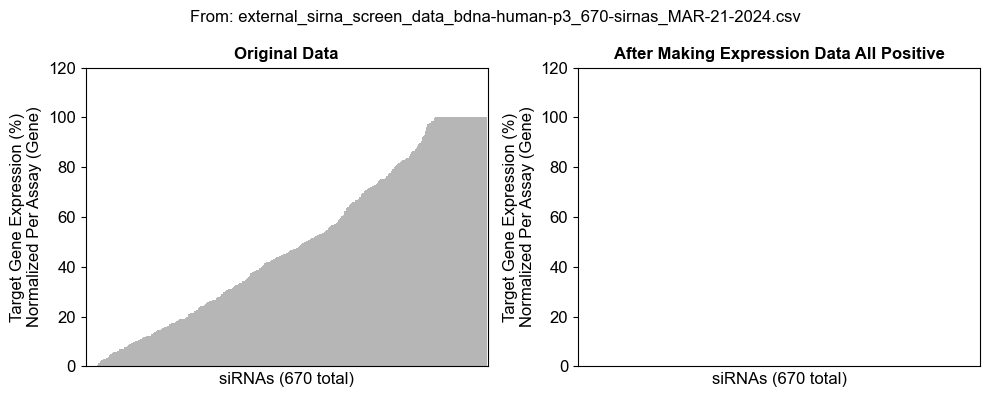

In [78]:
import pandas as pd
# input_data_file = 'newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024'
df = pd.read_csv('new_input_data/'+input_data_file+'.csv')
df

df['actual_expression_percent_normalized_by_max_min'] = df['expression_percent_normalized_by_max_min']

df['expression_percent_normalized_by_max_min'] = len(df)*[0.1]
df['expression_percent'] = len(df)*[0.1]

# Plot Data

fig, axs = plt.subplots(1,2)
fig.set_size_inches(w=10, h=4)

exp_key_1 = 'actual_expression_percent_normalized_by_max_min'

axs[0].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_1)[exp_key_1],
    color='#B6B6B7',
    # width=(1.0),
)

axs[0].set_ylim(0, max(df[exp_key_1]) + 0.2 * max(df[exp_key_1]))
axs[0].set_xlim(0, len(df))
axs[0].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[0].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[0].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[0].set_title('Original Data',fontweight='bold')

exp_key_2 = 'expression_percent_normalized_by_max_min'

axs[1].bar(
    x=list(range(len(df))),
    height=df.sort_values(by=exp_key_2)[exp_key_2], 
    color='#B6B6B7',
    # width=(1.0),
)

axs[1].set_ylim(0, max(df[exp_key_1]) + 0.2 * max(df[exp_key_1]))
axs[1].set_xlim(0, len(df))
axs[1].set_ylabel('Target Gene Expression (%)\nNormalized Per Assay (Gene)')
axs[1].set_xlabel('siRNAs (' + str(len(df)) + ' total)')
axs[1].tick_params(axis='x', bottom=False, labelbottom=False)  # remove x-axis ticks and labels
axs[1].set_title('After Making Expression Data All Positive',fontweight='bold')

fig.suptitle('From: '+input_data_file+'.csv')
fig.tight_layout()

# ** SAVE FIGURE **
plt.rcParams['svg.fonttype'] = 'none'  # exports text as strings rather than vector paths (images)
fnm_ = 'new_input_data/for_troubleshooting_and_testing/figures/'+'all-positive-labels_'+input_data_file
fig.savefig(fnm_ + '.svg', format='svg', transparent=True)

fig.savefig(fnm_ + '.png', format='png', dpi=300, transparent=False)
print('Figure saved to:', fnm_ + '.png')



df.drop(columns = ['actual_expression_percent_normalized_by_max_min'], inplace=True)




# Export randomized data
out_file = 'all-positive-labels_'+input_data_file+'.csv'
df.to_csv('new_input_data/for_troubleshooting_and_testing/'+out_file)
print("Data saved to:\n\t",'new_input_data/for_troubleshooting_and_testing/'+out_file)



# Remove bad data (JAK3 screen)

In [48]:
# # input_data_file = 'newly_added_sirna_screen_data_777-sirnas|-bdna_FEB-22-2024'
# df = pd.read_csv('new_input_data/old_newly_added_screening_data_777_containing_JAK3_bad_screen/'+input_data_file+'.csv')
# # df = pd.read_csv('new_input_data/'+'randomized_sirna_screen_data_777-sirnas_p3-bdna_FEB-28-2024.csv')
# min(df['expression_percent_normalized_by_max_min'])

# # Identify JAK3 bad screen (nothing worked)
# u
# indxs_to_remove_ = list(df[df['gene'] == 'JAK3'].index)
# max_ = max(df.iloc[indxs_to_remove_]['expression_percent'])
# min_ = min(df.iloc[indxs_to_remove_]['expression_percent'])

# print(min(df['expression_percent_normalized_by_max_min']),max(df['expression_percent_normalized_by_max_min']))

# print(max_,min_)

# df.drop(index=indxs_to_remove_,inplace=True)
# df.reset_index(inplace=True,drop=True)
# print(min(df['expression_percent_normalized_by_max_min']),max(df['expression_percent_normalized_by_max_min']))

# # Save corrected data

# out_fnm_='newly_added_sirna_screen_data_'+str(len(df))+'-sirnas|-bdna_'+'MAR-13-2024.csv'
# df.to_csv('new_input_data/'+out_fnm_)
# print(out_fnm_)


-4417.7886849393735 100.0
354.13641104747165 105.62523900010348
0.0220291949247113 100.0
newly_added_sirna_screen_data_765-sirnas|-bdna_MAR-13-2024.csv
